# Image Classification

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import os
import PIL

flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/

# Downloading the data using data directory

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 315s 1us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


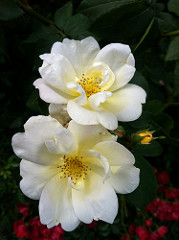

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

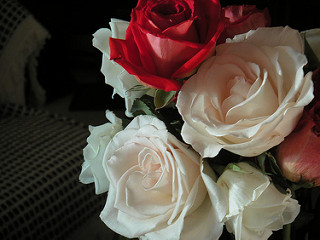

In [7]:
PIL.Image.open(str(roses[1]))

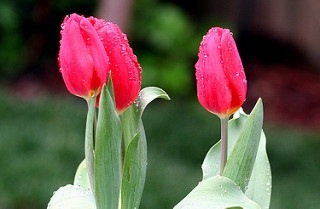

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

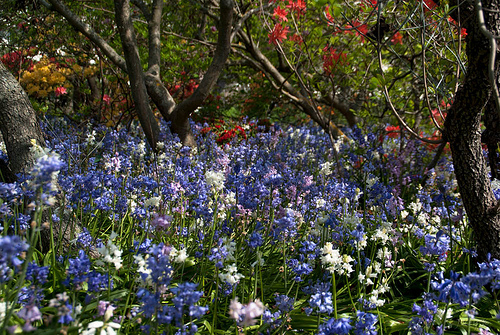

In [9]:
PIL.Image.open(str(tulips[1]))


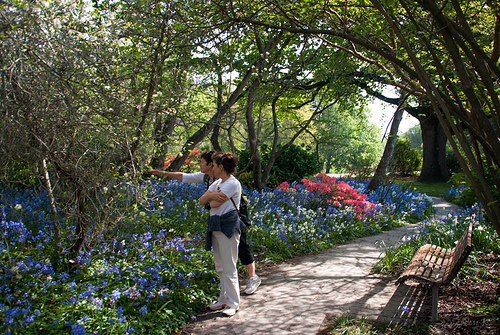

In [10]:
PIL.Image.open(str(tulips[2]))

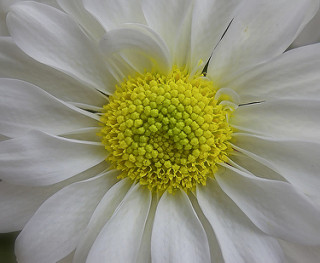

In [12]:
daisy=list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[0]))

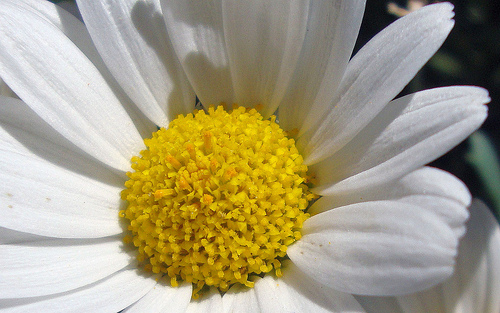

In [13]:
PIL.Image.open(str(daisy[1]))

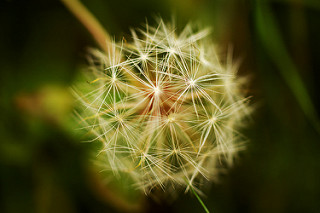

In [14]:
dandelion=list(data_dir.glob('dandelion/*'))
PIL.Image.open(str(dandelion[0]))

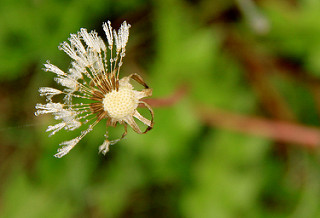

In [15]:
PIL.Image.open(str(dandelion[1]))

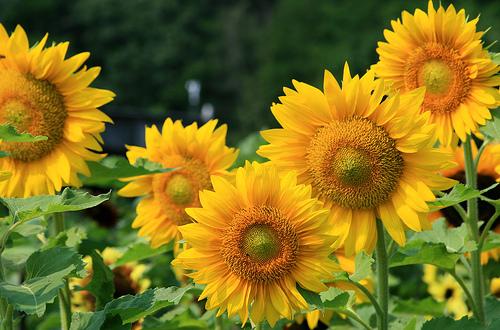

In [17]:
sunflowers=list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[0]))

# create_a_dataset

Let's load these images off disk using the helpful image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the load images tutorial.

In [18]:
batch_size=32
img_height=180
img_width=180

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


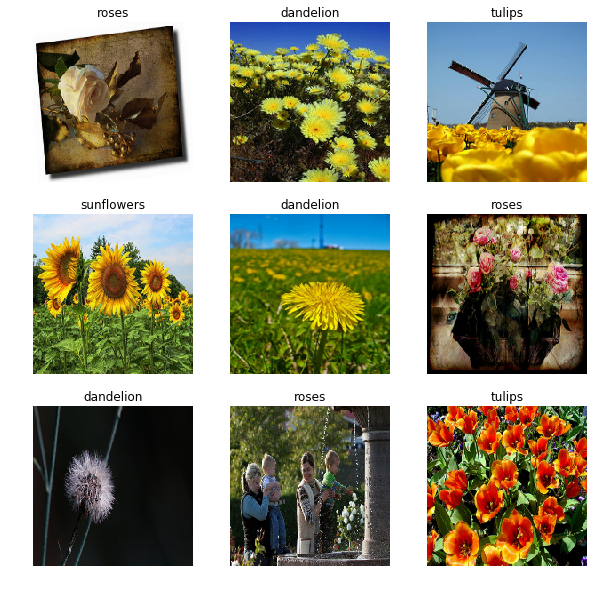

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [26]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.02886732 1.0


# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach.

In [28]:
num_classes = 5
from tensorflow.keras import Sequential
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [31]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 113s 1s/step - loss: 1.4535 - accuracy: 0.3680 - val_loss: 1.0361 - val_accuracy: 0.5858
Epoch 2/10
92/92 [==============================] - 62s 679ms/step - loss: 0.9494 - accuracy: 0.6214 - val_loss: 0.9564 - val_accuracy: 0.6322
Epoch 3/10
92/92 [==============================] - 63s 685ms/step - loss: 0.7843 - accuracy: 0.7081 - val_loss: 0.9006 - val_accuracy: 0.6417
Epoch 4/10
92/92 [==============================] - 63s 686ms/step - loss: 0.5382 - accuracy: 0.8111 - val_loss: 1.0626 - val_accuracy: 0.6281
Epoch 5/10
92/92 [==============================] - 62s 679ms/step - loss: 0.3713 - accuracy: 0.8698 - val_loss: 1.0686 - val_accuracy: 0.6499
Epoch 6/10
92/92 [==============================] - 62s 679ms/step - loss: 0.1766 - accuracy: 0.9487 - val_loss: 1.4857 - val_accuracy: 0.6213
Epoch 7/10
92/92 [==============================] - 61s 668ms/step - loss: 0.1307 - accuracy: 0.9647 - val_loss: 1.4413 - val_accuracy: 0.6458
E

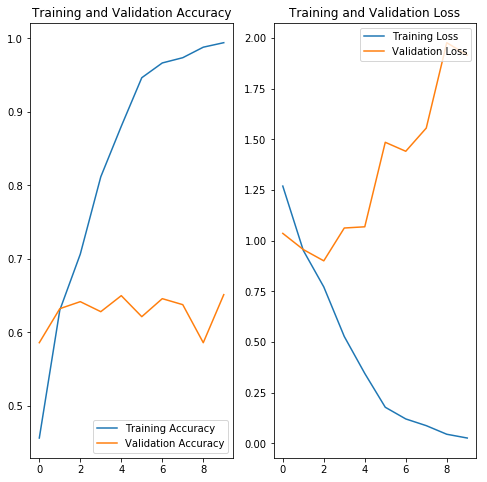

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data Augumentation and drop out to fight overfitting

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [34]:
from tensorflow import keras
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

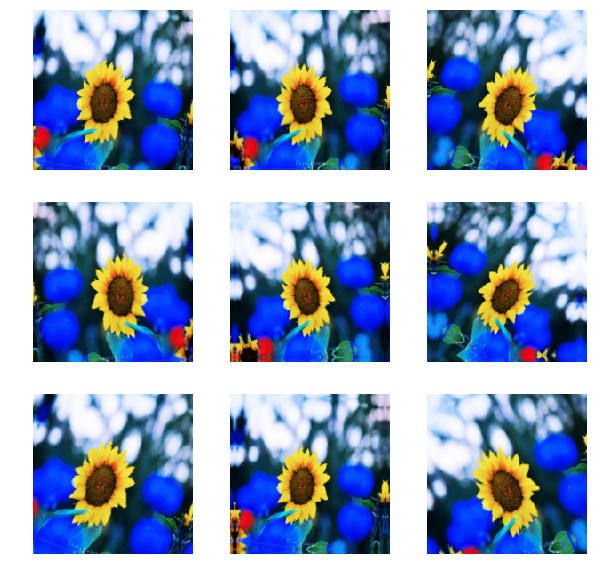

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Apply Drop out

In [36]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [39]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 72s 775ms/step - loss: 1.6101 - accuracy: 0.3022 - val_loss: 1.1397 - val_accuracy: 0.5368
Epoch 2/15
92/92 [==============================] - 72s 786ms/step - loss: 1.1580 - accuracy: 0.5152 - val_loss: 1.0255 - val_accuracy: 0.5790
Epoch 3/15
92/92 [==============================] - 72s 788ms/step - loss: 1.0302 - accuracy: 0.5890 - val_loss: 0.9859 - val_accuracy: 0.6131
Epoch 4/15
92/92 [==============================] - 72s 787ms/step - loss: 0.9194 - accuracy: 0.6382 - val_loss: 0.9075 - val_accuracy: 0.6553
Epoch 5/15
92/92 [==============================] - 72s 784ms/step - loss: 0.8456 - accuracy: 0.6694 - val_loss: 1.0197 - val_accuracy: 0.6144
Epoch 6/15
92/92 [==============================] - 72s 781ms/step - loss: 0.8168 - accuracy: 0.6849 - val_loss: 0.9093 - val_accuracy: 0.6444
Epoch 7/15
92/92 [==============================] - 72s 784ms/step - loss: 0.7428 - accuracy: 0.7154 - val_loss: 0.8121 - val_accuracy: 0.6757

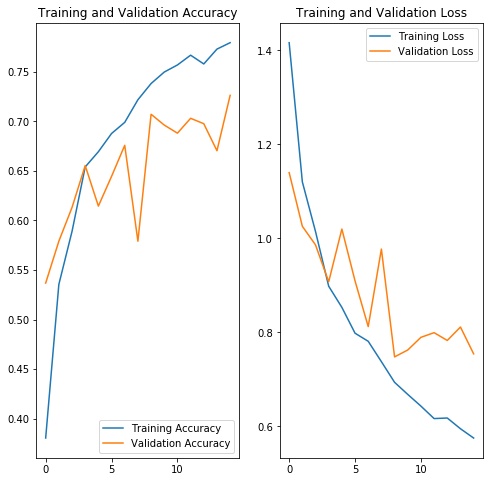

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predicting a new data

In [41]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 2s 16us/step
This image most likely belongs to sunflowers with a 99.98 percent confidence.
